In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import pandas as pd

import numpy as np
import torch

In [4]:
# set up logging
import logging

logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
    force=True,
)

### Configs

In [5]:
import args as args_loading

# used when run from command line
args = args_loading.parse_args()
# print(f"Parsing args = {args}")

In [6]:

run_name = args.get("run_name", "house_electric_fit_prior")

activation = args.get("activation", "nnsilu")
bnn_width = args.get("bnn_width", 128)

n_iterations = args.get("n_iterations", 4001)

generator_config_set_no = args.get("target", -12)
num_function_samples = args.get("num_function_samples", 1024)
batch_size = args.get("batch_size", 1024)

report_every_n_iterations = args.get("report_every_n_iterations", 250)
random_seed = args.get("random_seed", 1610)

In [7]:
print(f"Configuration = {locals()}")

Configuration = {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "get_ipython().run_line_magic('reload_ext', 'autoreload')\nget_ipython().run_line_magic('autoreload', '2')", 'import sys\nsys.path.append("..")', 'import pandas as pd\n\nimport numpy as np\nimport torch', '# set up logging\nimport logging\n\nlogging.basicConfig(\n    level=logging.INFO,\n    stream=sys.stdout,\n    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",\n    force=True,\n)', 'import args as args_loading\n\n# used when run from command line\nargs = args_loading.parse_args()\n# print(f"Parsing args = {args}")', 'run_name = args.get("run_name", "house_electric_fit_prior")\n\nactivation = args.get("activation", "nnsilu")\nbnn_width = args.get("bnn_width", 128)\n\nn_itera

### Data

In [8]:
import grids

from data.uci_household_power_consumption import load as data_src

In [9]:
datafile = "../data/uci_household_power_consumption/individual+household+electric+power+consumption.npy"

In [10]:
(
    x_train,
    y_train,
    x_test,
    y_test,
    y_train_r_mean,
    y_train_r_std,
    tt_split_hsh,
) = data_src.prepare_data(datafile=datafile)
print("data", x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train_r_mean, y_train_r_std, tt_split_hsh)

data torch.Size([1366186, 8]) torch.Size([1366186]) torch.Size([683094, 8]) torch.Size([683094]) tensor(9.3178) tensor(9.5873) 9d025f6b9a0637a8e6858f9ad33f3a12


In [11]:
x_min, x_max = grids.get_input_range(x_train.numpy(), x_test.numpy())
rand_generator = grids.MeasureSetGenerator(x_train.numpy(), x_min, x_max, 0.7)
create_training_grid = lambda n_nodes: rand_generator.get(n_nodes)

In [12]:
print(x_min, x_max)

[-1.0972173  -5.447677   -0.9972217  -0.18226153 -0.22281936 -0.76589495
 -1.7212899  -1.7317975 ] [11.236936   4.111009   9.858398  14.1361475 13.545257   2.908641
  1.7442578  1.7294537]


### Training prior

In [13]:
import train_priors_and_activations as train
import import_export

In [14]:
fit = train.run_main(
    run_name=run_name,
    ##############################
    activation=activation,
    bnn_width=bnn_width,
    generator_config_set_no=generator_config_set_no,  # generator configuration    
    create_parameter_sampler="create_factorized_sampler_gaussian_zero_loc",
    loss_func="wasserstein_distance",
    n_iterations=n_iterations,
    lr=0.01,
    report_every_n_iterations=report_every_n_iterations,
    batch_size=batch_size,
    num_function_samples=num_function_samples,
    shuffle_xs_n_times=1,
    freeze_training_grid=False,
    ##############################
    # Data:
    create_training_grid=create_training_grid,
    final_evaluation_batch_size=1024,
    ##############################
    random_seed=random_seed,
)

print("Storing fit into {run_name}_results.json")
import_export.save_to_json(run_name+"_results.json", fit)

[2025-01-16 16:43:37,995] {../train_priors_and_activations.py:372} WARNING - final_evaluation_input_grid is not set, creating one with create_training_grid with using #data-pts=124
[2025-01-16 16:43:38,037] {../train_priors_and_activations.py:395} INFO - Configuration: {'run_name': 'house_electric_fit_prior', 'generator_width': 1000, 'bnn_width': 128, 'loss_func': <function wasserstein_distance at 0x7fd3a1532e50>, 'create_parameter_sampler': <function create_factorized_sampler_gaussian_zero_loc at 0x7fd3a16f9c10>, 'activation': 'nnsilu', 'n_iterations': 41, 'lr': 0.01, 'report_every_n_iterations': 20, 'generator_config_set_no': -12, 'priors_config_set_no': None, 'input_data_range_config_set_no': None, 'batch_size': 124, 'num_function_samples': 124, 'shuffle_xs_n_times': 1, 'freeze_training_grid': False, 'create_training_grid': <function <lambda> at 0x7fd3a062f790>, 'sn2': 0.1, 'test_grid_n_nodes': None, 'final_evaluation_input_grid': tensor([[ 5.4655e+00, -4.9559e+00,  6.4339e+00,  9.5

  0%|          | 0/41 [00:00<?, ?it/s]

[2025-01-16 16:43:41,868] {../train_priors_and_activations.py:187} INFO - [it=0] loss= 1.395 wasserstein=1.395  [target vs learning]: mean = 0.01+/-0.20 vs 0.05+/-0.85,  std = 0.98+/-0.08 vs 0.04+/-0.01,  skewness = 0.02+/-0.24 vs -0.12+/-1.22,  kurtosis = -0.04+/-0.45 vs 1.50+/-1.12
[2025-01-16 16:43:41,869] {../train_priors_and_activations.py:203} INFO - priors variational_params={'fc1.weight.scale': '0.07', 'fc1.bias.scale': '0.19', 'fc2.weight.scale': '0.26', 'fc2.bias.scale': '0.47'}


 49%|████▉     | 20/41 [00:08<00:09,  2.12it/s]

[2025-01-16 16:43:50,792] {../train_priors_and_activations.py:187} INFO - [it=20] loss= 0.978 wasserstein=0.978  [target vs learning]: mean = 0.00+/-0.24 vs -0.02+/-0.44,  std = 0.99+/-0.09 vs 0.19+/-0.08,  skewness = -0.03+/-0.27 vs 0.11+/-1.23,  kurtosis = -0.04+/-0.48 vs 1.63+/-1.43
[2025-01-16 16:43:50,793] {../train_priors_and_activations.py:203} INFO - priors variational_params={'fc1.weight.scale': '0.08', 'fc1.bias.scale': '0.18', 'fc2.weight.scale': '0.24', 'fc2.bias.scale': '0.40'}


 98%|█████████▊| 40/41 [00:18<00:00,  2.02it/s]

[2025-01-16 16:44:00,479] {../train_priors_and_activations.py:187} INFO - [it=40] loss= 0.962 wasserstein=0.962  [target vs learning]: mean = 0.01+/-0.17 vs 0.04+/-0.38,  std = 0.99+/-0.09 vs 0.23+/-0.10,  skewness = 0.01+/-0.22 vs -0.23+/-1.16,  kurtosis = -0.01+/-0.42 vs 1.55+/-1.22
[2025-01-16 16:44:00,480] {../train_priors_and_activations.py:203} INFO - priors variational_params={'fc1.weight.scale': '0.09', 'fc1.bias.scale': '0.16', 'fc2.weight.scale': '0.24', 'fc2.bias.scale': '0.35'}


100%|██████████| 41/41 [00:19<00:00,  2.14it/s]

[2025-01-16 16:44:00,701] {../train_priors_and_activations.py:443} INFO - training history:
    iteration      loss        eta  wasserstein_distance  learning_mean_mean  \
0           0  1.395480   0.425684              1.395480            0.047474   
1           1  1.256988   0.864379                   NaN                 NaN   
2           2  1.225710   1.266233                   NaN                 NaN   
3           3  1.150231   1.667193                   NaN                 NaN   
4           4  1.084010   2.148135                   NaN                 NaN   
5           5  1.045631   2.570288                   NaN                 NaN   
6           6  0.955594   3.000746                   NaN                 NaN   
7           7  0.954082   3.447331                   NaN                 NaN   
8           8  0.968000   3.868277                   NaN                 NaN   
9           9  0.979313   4.290273                   NaN                 NaN   
10         10  0.979446   4.

[2025-01-16 16:44:02,913] {../train_priors_and_activations.py:68} INFO - Evaluation loss: 0.9297274947166443
[2025-01-16 16:44:03,341] {../train_priors_and_activations.py:71} INFO - Calculating distributional metrics for priors = {'1-Wasserstein': 11.039214342832565, '2-Wasserstein': 11.090015791478612, 'Linear_MMD': -0.10070540010929108, 'Poly_MMD': 465.2372131347656, 'RBF_MMD': 0.1391751766204834, 'Mean_MSE': 0.001344579621218145, 'Mean_L2': 0.036668509939976356, 'Mean_L1': 0.029772566631436348, 'Median_MSE': 0.002254422986879945, 'Median_L2': 0.047480764388117686, 'Median_L1': 0.0376787893474102}
Storing fit into {run_name}_results.json
[2025-01-16 16:44:03,344] {../import_export.py:268} INFO - [import_export] Writing to house_electric_fit_prior_results.json
[2025-01-16 16:44:03,347] {../import_export.py:55} INFO - [import_export] Failed to dump <targets_gp.GPGenerator1D object at 0x7fd3a17fbbb0> to JSON (Object of type GPGenerator1D is not JSON serializable). Pickling instead.
[202

{'prior_type': 'gaussian',
 'net_width': 128,
 'evaluation': {'final_loss': 0.9297274947166443,
  '1-Wasserstein': 11.039214342832565,
  '2-Wasserstein': 11.090015791478612,
  'Linear_MMD': -0.10070540010929108,
  'Poly_MMD': 465.2372131347656,
  'RBF_MMD': 0.1391751766204834,
  'Mean_MSE': 0.001344579621218145,
  'Mean_L2': 0.036668509939976356,
  'Mean_L1': 0.029772566631436348,
  'Median_MSE': 0.002254422986879945,
  'Median_L2': 0.047480764388117686,
  'Median_L1': 0.0376787893474102},
 'initial_performance': {'final_loss': 1.3448753356933594,
  '1-Wasserstein': 12.698966268450022,
  '2-Wasserstein': 12.943965469981734,
  'Linear_MMD': -4.0183305740356445,
  'Poly_MMD': 6524.58349609375,
  'RBF_MMD': 0.17562174797058105,
  'Mean_MSE': 0.0007591457688249648,
  'Mean_L2': 0.02755260003747314,
  'Mean_L1': 0.02211349830031395,
  'Median_MSE': 0.0015650105196982622,
  'Median_L2': 0.03956021384798447,
  'Median_L1': 0.03231939673423767},
 'generator': {'name': '<targets_gp.GPGenerator1

### Training prior results

In [15]:
pd.DataFrame({"final": fit["evaluation"], "initial": fit["initial_performance"]}).round(2)

final  initial
final_loss       0.93     1.34
1-Wasserstein   11.04    12.70
2-Wasserstein   11.09    12.94
Linear_MMD      -0.10    -4.02
Poly_MMD       465.24  6524.58
RBF_MMD          0.14     0.18
Mean_MSE         0.00     0.00
Mean_L2          0.04     0.03
Mean_L1          0.03     0.02
Median_MSE       0.00     0.00
Median_L2        0.05     0.04
Median_L1        0.04     0.03

In [16]:
history = pd.DataFrame(fit["history"])
history

iteration      loss        eta  wasserstein_distance  learning_mean_mean  \
0           0  1.395480   0.425684              1.395480            0.047474   
1           1  1.256988   0.864379                   NaN                 NaN   
2           2  1.225710   1.266233                   NaN                 NaN   
3           3  1.150231   1.667193                   NaN                 NaN   
4           4  1.084010   2.148135                   NaN                 NaN   
5           5  1.045631   2.570288                   NaN                 NaN   
6           6  0.955594   3.000746                   NaN                 NaN   
7           7  0.954082   3.447331                   NaN                 NaN   
8           8  0.968000   3.868277                   NaN                 NaN   
9           9  0.979313   4.290273                   NaN                 NaN   
10         10  0.979446   4.678308                   NaN                 NaN   
11         11  1.004199   5.186722                   NaN                 NaN   
12         12  0.979596   5.611152                   NaN                 NaN   
13         13  0.990865   6.038012                   NaN                 NaN   
14         14  1.007100   6.519873                   NaN                 NaN   
15         15  0.975468   6.974153                   NaN                 NaN   
16         16  1.004186   7.409708                   NaN                 NaN   
17         17  1.019830   7.934639                   NaN                 NaN   
18         18  0.961487   8.425682                   NaN                 NaN   
19         19  0.985191   8.890440                   NaN                 NaN   
20         20  0.977782   9.348511              0.977782           -0.017386   
21         21  0.976790   9.917890                   NaN                 NaN   
22         22  0.972109  10.438300                   NaN                 NaN   
23         23  0.928244  10.898515                   NaN                 NaN   
24         24  0.979408  11.355129                   NaN                 NaN   
25         25  0.936688  11.812345                   NaN                 NaN   
26         26  0.942307  12.261133                   NaN                 NaN   
27         27  0.922579  12.818609                   NaN                 NaN   
28         28  0.931227  13.288599                   NaN                 NaN   
29         29  0.973611  13.785756                   NaN                 NaN   
30         30  0.923978  14.233928                   NaN                 NaN   
31         31  0.945873  14.725474                   NaN                 NaN   
32         32  0.928594  15.230293                   NaN                 NaN   
33         33  0.960523  15.702416                   NaN                 NaN   
34         34  0.911789  16.142012                   NaN                 NaN   
35         35  0.914629  16.615292                   NaN                 NaN   
36         36  0.925048  17.110557                   NaN                 NaN   
37         37  0.964927  17.612775                   NaN                 NaN   
38         38  0.920421  18.077135                   NaN                 NaN   
39         39  0.936269  18.617373                   NaN                 NaN   
40         40  0.962149  19.035353              0.962149            0.039374   

    learning_mean_std  learning_std_mean  learning_std_std  \
0            0.853480           0.035085          0.013277   
1                 NaN                NaN               NaN   
2                 NaN                NaN               NaN   
3                 NaN                NaN               NaN   
4                 NaN                NaN               NaN   
5                 NaN                NaN               NaN   
6                 NaN                NaN               NaN   
7                 NaN                NaN               NaN   
8                 NaN                NaN               NaN   
9                 NaN  

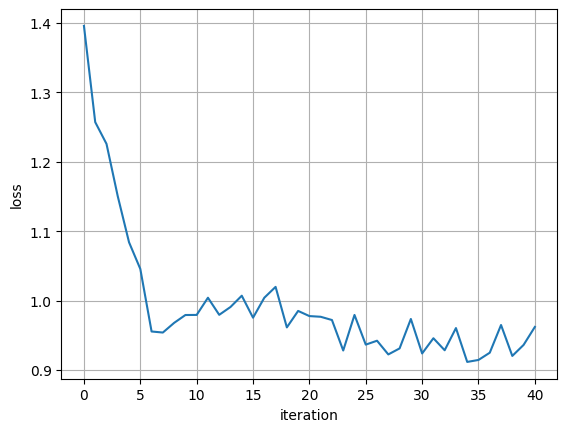

In [17]:
from matplotlib import pyplot as plt

plt.plot(history["iteration"], history["loss"])
plt.xlabel("iteration")
plt.ylabel("loss");
# plt.legend()
plt.grid(True)
plt.show()

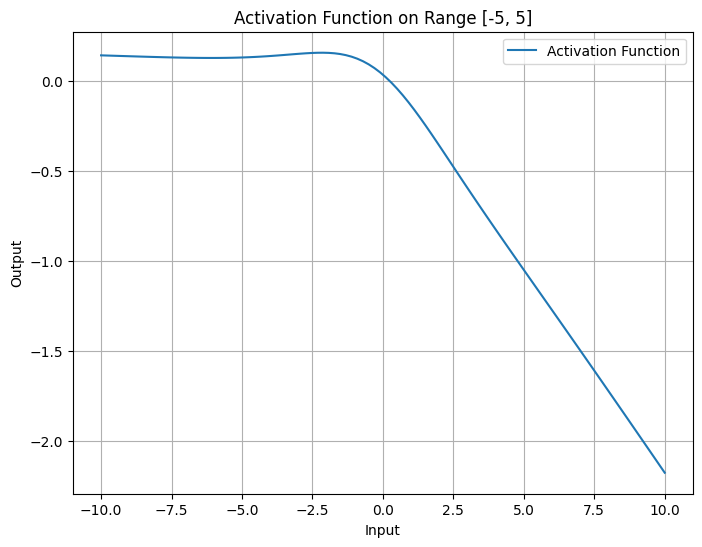

In [18]:
# Generate input values
x_values = np.linspace(-10, 10, 100)

# Get the activation function from the fit dictionary
activation_function = fit["activation"]

# Compute the output values
y_values = activation_function(torch.tensor(x_values, dtype=torch.float32)).detach().numpy()

# Plot the activation function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Activation Function on Range [-5, 5]')
plt.legend()
plt.grid(True)
plt.show()